In [1]:
import pandas as pd
import glob
import numpy as np

import datetime as dt
import plotly.graph_objects as go
import random

import imgkit
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.style as style
style.use('fivethirtyeight')
import scipy.stats as stats

from scipy.stats import pearsonr

In [2]:
# Import ROC analysis simulated data 
df = pd.read_excel('ROC Analysis simulated data.xlsx',
             sheet_name='ROC Analysis simulated data',
             header = 0)

In [3]:
df.head()

,leak_ID,actual_flow_rate,measurement_A,measurement_B,A_detect,B_detect
0,1,0,6.20,2.50,Yes,No
1,2,1,3.33,2.99,No,No
2,3,3,4.32,3.86,Yes,Yes
3,4,4,3.92,4.10,No,Yes
4,5,0,3.40,3.52,No,Yes


In [4]:
threshold_A = 4 #arbitrary starting threshold
threshold_B = 3.5 #arbitrary starting threshold

lr_goal = 0 # the threshold leak rate is zero

In [5]:
# Plot the leak detection probability curves

bins = 5
bin_limits = [0, 4, 8, 12, 16, 20]

assert len(bin_limits) == bins + 1

def binned_data(df, meas_col, bins, bin_limits, threshold):
    """
    Function to produce a DataFrame containing values of binned number of detects and non-detects
    
    :params df: DataFrame containing instrument measurement values
    :params meas_col: column name string of instrument measurement value
    :params bins: number of bins to create
    :params bin_limits: a list containing bin boundaries in increasing order
    :params threshold: threshold for the instrument
    
    :return: DataFrame with binned detects and non-detects
    """
    df_b = pd.DataFrame()
    
    string_list = []
    for i in range(len(bin_limits) - 1):
        string = str(bin_limits[i]) + " - " + str(bin_limits[i + 1]) + " scfh"
        string_list.append(string)
        
    df_b['bins'] = pd.Series(string_list)
    df_b['lower'] = pd.Series(bin_limits[:-1])
    df_b['higher'] = pd.Series(bin_limits[1:])
    
    # Count number of detects by excluding blank leaks (leak rate = 0 scfh)
    # IMPORTANT bin: lower_boundary < leak_rate <= higher_boundary
    df_b['detect'] = df_b.apply(lambda row: df[(df['actual_flow_rate'] > row['lower']) & 
                                               (df['actual_flow_rate'] <= row['higher']) &
                                               (df['actual_flow_rate'] != 0) &
                                               (df[meas_col] > threshold)][meas_col].count(), axis = 1)
    
    df_b['non_detect'] =df_b.apply(lambda row: df[(df['actual_flow_rate'] > row['lower']) & 
                                               (df['actual_flow_rate'] <= row['higher']) &
                                               (df['actual_flow_rate'] != 0) &
                                               (df[meas_col] < threshold)][meas_col].count(), axis = 1)
    
    df_b['%_detection'] = df_b['detect'] /(df_b['detect'] + df_b['non_detect']) * 100
    
    # Calculate the average leak rate in each bin
    df_b['ave_bin'] = df_b.apply(lambda row: df[(df['actual_flow_rate'] > row['lower']) & 
                                               (df['actual_flow_rate'] <= row['higher']) &
                                               (df['actual_flow_rate'] != 0)]['actual_flow_rate'].mean(), axis = 1)
    return df_b

In [6]:
df_ba = binned_data(df, 'measurement_A', bins, bin_limits, threshold_A)
df_bb = binned_data(df, 'measurement_B', bins, bin_limits, threshold_B)

In [7]:
df_ba

,bins,lower,higher,detect,non_detect,%_detection,ave_bin
0,0 - 4 scfh,0,4,3,3,50.000000,2.833333
1,4 - 8 scfh,4,8,4,2,66.666667,6.500000
2,8 - 12 scfh,8,12,3,0,100.000000,11.666667
3,12 - 16 scfh,12,16,1,1,50.000000,14.500000
4,16 - 20 scfh,16,20,3,1,75.000000,18.500000


In [8]:
df_bb

,bins,lower,higher,detect,non_detect,%_detection,ave_bin
0,0 - 4 scfh,0,4,4,2,66.666667,2.833333
1,4 - 8 scfh,4,8,4,2,66.666667,6.500000
2,8 - 12 scfh,8,12,2,1,66.666667,11.666667
3,12 - 16 scfh,12,16,2,0,100.000000,14.500000
4,16 - 20 scfh,16,20,4,0,100.000000,18.500000


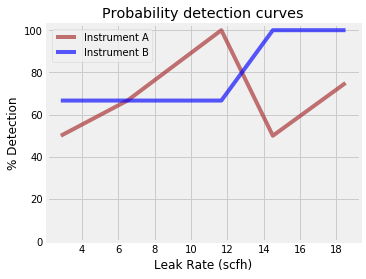

In [9]:
# Plot leak detection probability line charts

plt.figure(figsize=(5,4))

sns.lineplot(x='ave_bin', y='%_detection',data=df_ba, color = 'brown', alpha=0.65)
sns.lineplot(x='ave_bin', y='%_detection',data=df_bb, color ='blue', alpha = 0.65)
plt.xlabel('Leak Rate (scfh)')
plt.ylabel('% Detection')
plt.ylim(0,103)
plt.title('Probability detection curves')

plt.legend(["Instrument A", "Instrument B"])
plt.show()

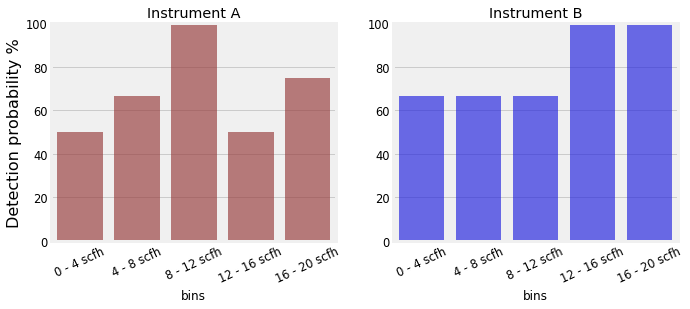

In [36]:
# Plot leak detection probability histogram

fig ,(ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

sns.barplot(x='bins', y='%_detection',data=df_ba, color = 'brown', alpha=0.65, ax=ax1)
sns.barplot(x='bins', y='%_detection',data=df_bb, color ='blue', alpha = 0.65, ax=ax2)
ax1.set_ylim(0,100)
ax2.set_ylim(0,100)
ax1.set_ylabel("Detection probability %", fontsize = 16)
ax2.set_ylabel("")
ax1.set_xticklabels(df_ba['bins'], rotation = 25, fontsize = 11.5)
ax2.set_xticklabels(df_bb['bins'], rotation = 25, fontsize = 11.5)

ax1.tick_params(axis='both', which='major', labelsize=11.5)
ax2.tick_params(axis='both', which='major', labelsize=11.5)

ax1.title.set_text('Instrument A')
ax2.title.set_text('Instrument B')

plt.show()


C:\Users\GBong\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0, 0.5, 'Frequency')

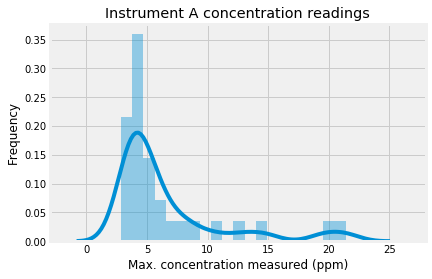

In [11]:
# Plot flow rate vs. max concentration measured in 4 surfaces

bin_count = 20

sns.distplot(df['measurement_A'], bins = bin_count)
plt.title('Instrument A concentration readings')
plt.xlim(-3, 28)
plt.xlabel('Max. concentration measured (ppm)')
plt.ylabel('Frequency')

Text(0.5, 1.0, 'Distribution of detect/non-detect leaks by instrument A')

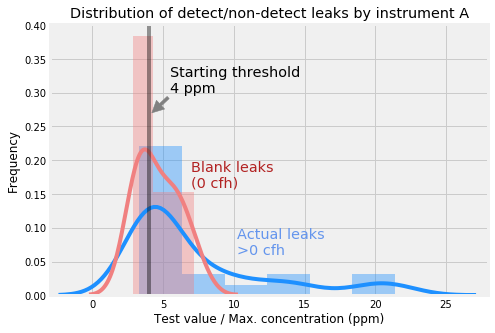

In [12]:
# Plots the "positive" and "negative" cases along the test value on the x-axis
# the test_value here is Average concentration

yes = df[df['actual_flow_rate'] > lr_goal]['measurement_A'] 
no = df[df['actual_flow_rate'] <= lr_goal]['measurement_A']

plt.figure(figsize=(7,5))
sns.distplot(yes, color='dodgerblue')
sns.distplot(no, color='lightcoral')

plt.annotate('Actual leaks\n>{:d} cfh'.format(lr_goal), xy= (10.2, 0.06), fontsize= 'x-large', color='cornflowerblue')
plt.annotate('Blank leaks\n({:d} cfh)'.format(lr_goal), xy=(7, 0.16), fontsize='x-large', color='firebrick')
plt.annotate('Starting threshold\n{:.0f} ppm'.format(threshold_A), xy=(4.2, 0.27), xytext=(5.5,0.3),
             fontsize='x-large', color='black',
            arrowprops={'width' : 3, 'color':'gray'})

plt.xlim(-3, 28)
plt.xlabel('Test value / Max. concentration (ppm)', fontsize='large')
plt.ylabel('Frequency',fontsize='large')

plt.axvline(x=threshold_A, alpha =0.4, color='black')
plt.title('Distribution of detect/non-detect leaks by instrument A')

Text(0, 0.5, 'Frequency')

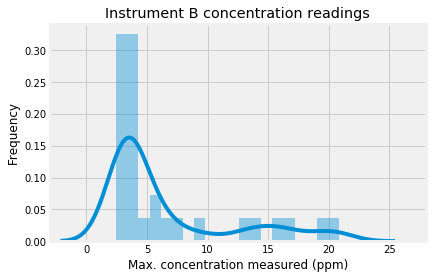

In [13]:
sns.distplot(df['measurement_B'], bins = bin_count)
plt.title('Instrument B concentration readings')
plt.xlim(-3, 28)
plt.xlabel('Max. concentration measured (ppm)')
plt.ylabel('Frequency')

Text(0.5, 1.0, 'Distribution of detect/non-detect leaks by instrument B')

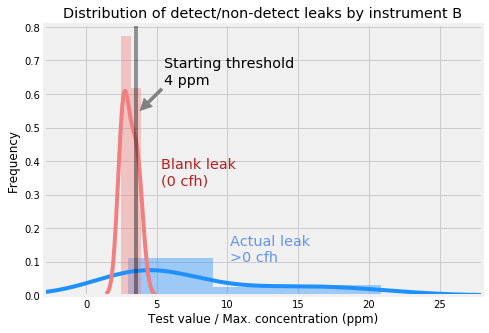

In [14]:
# Plots the "positive" and "negative" cases along the test value on the x-axis
# the test_value here is Average concentration

yes = df[df['actual_flow_rate'] > lr_goal]['measurement_B'] 
no = df[df['actual_flow_rate'] <= lr_goal]['measurement_B']

plt.figure(figsize=(7,5))
sns.distplot(yes, color='dodgerblue')
sns.distplot(no, color='lightcoral')

plt.annotate('Actual leak\n>{:d} cfh'.format(lr_goal), xy= (10.2, 0.10), fontsize= 'x-large', color='cornflowerblue')
plt.annotate('Blank leak\n({:d} cfh)'.format(lr_goal), xy=(5.3, 0.33), fontsize='x-large', color='firebrick')
plt.annotate('Starting threshold\n{:.0f} ppm'.format(threshold_B), xy=(3.8, 0.55), xytext=(5.5,0.63),
             fontsize='x-large', color='black',
            arrowprops={'width' : 3, 'color':'gray'})

plt.xlim(-3, 28)
plt.xlabel('Test value / Max. concentration (ppm)', fontsize='large')
plt.ylabel('Frequency',fontsize='large')

plt.axvline(x=threshold_B, alpha =0.4, color='black')
plt.title('Distribution of detect/non-detect leaks by instrument B')

In [15]:
def calc_stats_metrics(df, test_value, threshold, lr_goal):
    """ Calculates the true positive, true negative, false positive, false negative counts
        for a given threshold. test_value is the name of column that will be 
        compared with the threshold
        
        For this dataset, the test_value is either "measurement_A" or "measurement_B"
    """
    tp = df[(df[test_value]>threshold) & (df['actual_flow_rate']>lr_goal)][test_value].count()
    tn = df[(df[test_value]<=threshold) & (df['actual_flow_rate']<=lr_goal)][test_value].count()
    fp = df[(df[test_value]>threshold) & (df['actual_flow_rate']<=lr_goal)][test_value].count()
    fn = df[(df[test_value]<=threshold) & (df['actual_flow_rate']>lr_goal)][test_value].count()
    
    return tp, tn, fp, fn

In [16]:
# Create a new dataframe to store the performance metrics for instrument A

df_pa = pd.DataFrame()
df_pa['threshold'] = [*range(-1, int(df['measurement_A'].max(axis=0)) + 3, 1)] # threshold values -1-101 with an interval of 1

# Calculate the 4 metrics using calc_stats_metrics function, zip(*result) unpacks the values to 4 variables
# apply allows us to treat the data on a row basis. An inefficient way to do this is to create one column at a time

df_pa['tp'], df_pa['tn'], df_pa['fp'], df_pa['fn'] = zip(*df_pa.apply(lambda x: 
                                                    calc_stats_metrics(df, 'measurement_A', x['threshold'], lr_goal), 
                                                    axis=1))

df_pa['total'] = df_pa[['tp', 'tn', 'fp', 'fn']].sum(axis=1)

# Calculate the TPR and FPR in the data frame
# TPR = TP/(TP + FN)
# FPR = FP/(TN + FP)
# FNR = FN/(FN + TP)
df_pa['tpr'] = df_pa['tp']/(df_pa['tp'] + df_pa['fn'])
df_pa['fpr'] = df_pa['fp']/(df_pa['tn'] + df_pa['fp'])
df_pa['fnr'] = df_pa['fn']/(df_pa['fn'] + df_pa['tp'])

# calculate trapezoidal area under curve for each segment (0.5 * (average height) * base length)
df_pa['auc'] = 0.5*(df_pa['tpr'] + df_pa['tpr'].shift(-1)) * (df_pa['fpr'] - df_pa['fpr'].shift(-1))

df_pa.head()

,threshold,tp,tn,fp,fn,total,tpr,fpr,fnr,auc
0,-1,21,0,9,0,30,1.0,1.000000,0.0,0.000000
1,0,21,0,9,0,30,1.0,1.000000,0.0,0.000000
2,1,21,0,9,0,30,1.0,1.000000,0.0,0.000000
3,2,21,0,9,0,30,1.0,1.000000,0.0,0.111111
4,3,21,1,8,0,30,1.0,0.888889,0.0,0.277778


In [17]:
# Create a new dataframe to store the performance metrics for instrument A

df_pb = pd.DataFrame()
df_pb['threshold'] = [*range(-1, int(df['measurement_B'].max(axis=0)) + 3, 1)] # threshold values -1-101 with an interval of 1

# Calculate the 4 metrics using calc_stats_metrics function, zip(*result) unpacks the values to 4 variables
# apply allows us to treat the data on a row basis. An inefficient way to do this is to create one column at a time

df_pb['tp'], df_pb['tn'], df_pb['fp'], df_pb['fn'] = zip(*df_pb.apply(lambda x: 
                                                    calc_stats_metrics(df, 'measurement_B', x['threshold'], lr_goal), 
                                                    axis=1))

df_pb['total'] = df_pb[['tp', 'tn', 'fp', 'fn']].sum(axis=1)

# Calculate the TPR, FPR, FNR in the data frame
# TPR = TP/(TP + FN)
# FPR = FP/(TN + FP)
# FNR = FN/(FN + TP)
df_pb['tpr'] = df_pb['tp']/(df_pb['tp'] + df_pb['fn'])
df_pb['fpr'] = df_pb['fp']/(df_pb['tn'] + df_pb['fp'])
df_pb['fnr'] = df_pb['fn']/(df_pb['fn'] + df_pb['tp'])

# calculate trapezoidal area under curve for each segment (0.5 * (average height) * base length)
df_pb['auc'] = 0.5*(df_pb['tpr'] + df_pb['tpr'].shift(-1)) * (df_pb['fpr'] - df_pb['fpr'].shift(-1))

df_pb.head()

,threshold,tp,tn,fp,fn,total,tpr,fpr,fnr,auc
0,-1,21,0,9,0,30,1.000000,1.000000,0.000000,0.000000
1,0,21,0,9,0,30,1.000000,1.000000,0.000000,0.000000
2,1,21,0,9,0,30,1.000000,1.000000,0.000000,0.000000
3,2,21,0,9,0,30,1.000000,1.000000,0.000000,0.542328
4,3,20,5,4,1,30,0.952381,0.444444,0.047619,0.359788


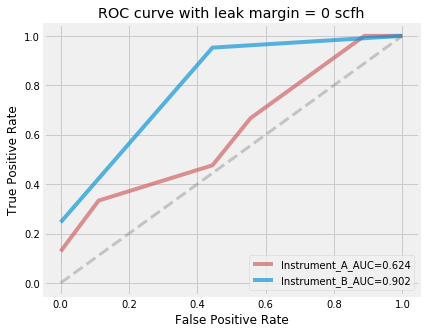

In [18]:
# plot both ave and max conc. AUC under the same graph
auc_a = df_pa['auc'].sum()
auc_b = df_pb['auc'].sum()

plt.figure(figsize=(6,5))

sns.lineplot(x='fpr', y='tpr',data=df_pa, color = 'indianred', alpha=0.65)
sns.lineplot(x='fpr', y='tpr',data=df_pb, alpha = 0.65)
plt.plot([0,1], [0,1], color='gray', alpha=0.4, linewidth=3, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve with leak margin = {:d} scfh'.format(lr_goal))

plt.legend(["Instrument_A_AUC=%.3f"%auc_a, "Instrument_B_AUC=%.3f"%auc_b])
plt.show()


### The curve does not start at 0,0 because our negative case is when leak rate is 0 scfh,
# even if we say all the leaks are 

Text(0, 0.5, 'Missed leak rate')

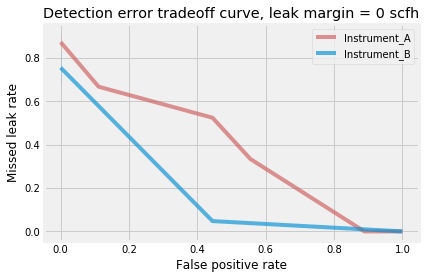

In [19]:
# Plot the detection error tradeoff lines, fn vs. fp

sns.lineplot(x='fpr', y='fnr',data=df_pa, color = 'indianred', alpha=0.65)
sns.lineplot(x='fpr', y='fnr',data=df_pb, alpha = 0.65)

plt.legend(["Instrument_A", "Instrument_B"])

plt.title('Detection error tradeoff curve, leak margin = {} scfh'.format(lr_goal))
plt.xlabel('False positive rate')
plt.ylabel('Missed leak rate')